# Detect AI vs. Human-Generated Images
This dataset comes from Kaggle.
https://www.kaggle.com/competitions/detect-ai-vs-human-generated-images

## Purpose
The purpose is to develop a model to distinguish between AI generated and human generated images. The dataset includes image pairs of human generated images that were captioned and AI generated images based on the captions.

## EDA
Below are pairs of example images to visualize the nature of the dataset.

In [1]:
%pip install kagglehub --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Kaggle provide the following code when you click on the Download button
# import kagglehub

# Download latest version
# path = kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")
# I've cached my own version of the dataset
path = "/teamspace/studios/this_studio"
print("Path to dataset files:", path)

Path to dataset files: /teamspace/studios/this_studio


In [3]:
import pandas as pd

train_df = pd.read_csv(path + "/train.csv")
test_df = pd.read_csv(path + "/test.csv")

print(train_df.head())
print(test_df.head())

# the dataframe contain labels and filenames to the images

   Unnamed: 0                                        file_name  label
0           0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1           1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
2           2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3           3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4           4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1
                                                  id
0  test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
1  test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
2  test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
3  test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
4  test_data_v2/a16495c578b7494683805484ca27cf9f.jpg


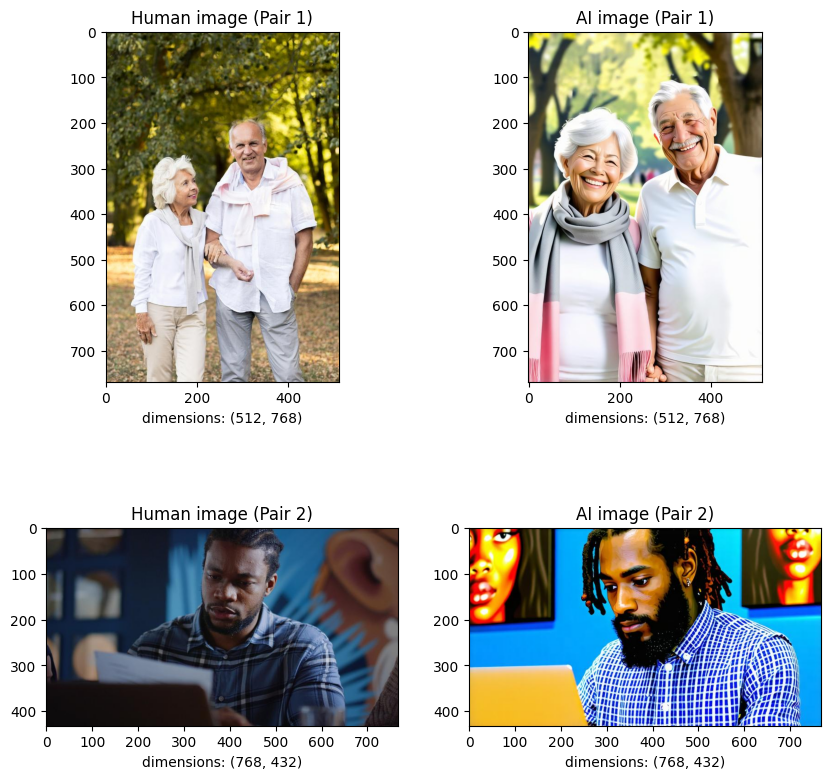

In [4]:
from PIL import Image
from matplotlib import pyplot as plt

# Load the first pair of images
human_image1 = Image.open(path + "/" + train_df[train_df["label"] == 0]["file_name"].iloc[0])
ai_image1 = Image.open(path + "/" + train_df[train_df["label"] == 1]["file_name"].iloc[0])

# Load the second pair of images
from random import randint
i = randint(1, len(train_df[train_df["label"] == 0]))
human_image2 = Image.open(path + "/" + train_df[train_df["label"] == 0]["file_name"].iloc[i])
ai_image2 = Image.open(path + "/" + train_df[train_df["label"] == 1]["file_name"].iloc[i])

# Create a figure with 2 rows and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# First row: first pair of images
axes[0, 0].imshow(human_image1)
axes[0, 0].set_title("Human image (Pair 1)")
dimensions = human_image1.size
axes[0, 0].set_xlabel(f"dimensions: {dimensions}")

axes[0, 1].imshow(ai_image1)
axes[0, 1].set_title("AI image (Pair 1)")
dimensions = ai_image1.size
axes[0, 1].set_xlabel(f"dimensions: {dimensions}")

# Second row: second pair of images
axes[1, 0].imshow(human_image2)
axes[1, 0].set_title("Human image (Pair 2)")
dimensions = human_image2.size
axes[1, 0].set_xlabel(f"dimensions: {dimensions}")

axes[1, 1].imshow(ai_image2)
axes[1, 1].set_title("AI image (Pair 2)")
dimensions = ai_image2.size
axes[1, 1].set_xlabel(f"dimensions: {dimensions}")

plt.show()


## EDA cont...
The images are in a variety of sizes and aspect ratios all with some sidelength of 768 and a second sidelength of a variety of values. Most of the images are RGB with a few black and white images.

The model will require transformations to a consistent size and aspect ratio. Also, the black and white images will be transformed to RGB images.

In [5]:
# Check all of the images and list all dimensions
dimensions = set()
modes = set()
for file_name in train_df["file_name"]:
    image = Image.open(path + "/" + file_name)
    dimensions.add(image.size)
    modes.add(image.mode)

print(dimensions)
print(modes)

{(768, 576), (480, 768), (768, 640), (416, 768), (768, 704), (656, 768), (768, 768), (592, 768), (704, 768), (528, 768), (352, 768), (640, 768), (768, 176), (768, 112), (768, 240), (768, 304), (768, 368), (768, 432), (768, 496), (768, 560), (464, 768), (768, 624), (768, 688), (768, 752), (576, 768), (752, 768), (688, 768), (512, 768), (336, 768), (768, 160), (448, 768), (400, 768), (768, 224), (768, 288), (624, 768), (768, 352), (768, 416), (768, 480), (768, 544), (768, 608), (768, 672), (736, 768), (768, 736), (560, 768), (384, 768), (496, 768), (320, 768), (768, 144), (432, 768), (768, 208), (768, 272), (768, 336), (768, 528), (768, 400), (768, 592), (768, 464), (768, 656), (768, 720), (672, 768), (608, 768), (720, 768), (544, 768), (768, 128), (368, 768), (768, 192), (768, 256), (768, 320), (768, 384), (768, 448), (768, 512)}
{'RGB', 'L'}

KeyboardInterrupt: 

## EDA cont...
Both for my own model as well as a ResNet based model, normalizing on dataset statistics is a good practice. The good below generates the statistics for the dataset. I use a transform to resize to the image size I intend to use for both models (512x512).

### Statistics
Mean: [0.6238067150115967, 0.5922583341598511, 0.5293540358543396]

Std: [0.3335755169391632, 0.3218654990196228, 0.3552871346473694]

In [4]:
from ImageDataset import ImageDataset
import torch
from torchvision import transforms

# Transform: Convert to Tensor only (no normalization yet)
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

stat_dataset = ImageDataset(path, train_df, transform=transform)
loader = torch.utils.data.DataLoader(stat_dataset, batch_size=64, shuffle=False, num_workers=4)

# Compute mean and std
sum_channels = torch.zeros(3)
sum_squared_channels = torch.zeros(3)
n_samples = 0  # Track the actual number of image samples

for batch in loader:
    images = batch[0]  # Extract only images, ignore labels
    batch_samples = images.size(0)  # Actual batch size (handles smaller last batch)
    images = images.view(batch_samples, 3, -1)  # Flatten spatial dimensions

    # Accumulate sum and squared sum per channel
    sum_channels += images.sum(dim=[0, 2])  # Sum of pixel values
    sum_squared_channels += (images ** 2).sum(dim=[0, 2])  # Sum of squared pixel values
    n_samples += batch_samples  # Keep track of actual image count

# Compute mean and std per channel
mean = sum_channels / (n_samples * images.shape[2])  # Divide by total number of pixels
std = torch.sqrt((sum_squared_channels / (n_samples * images.shape[2])) - (mean ** 2))  # std = sqrt(E[X²] - (E[X])²)

print("Mean:", mean.tolist())
print("Std:", std.tolist())

Mean: [0.6238067150115967, 0.5922583341598511, 0.5293540358543396]
Std: [0.3335755169391632, 0.3218654990196228, 0.3552871346473694]


# Data Cleaning
torchvision transformers will be used to convert images all to RGB format and a common size of 512x512

There are no known mistakes in the dataset to address.

## Pytorch with Lightning
I've been learning Pytorch and Lightning as an alternative to Tensorflow and Keras. The newer libraries are more popular and Lightning provides significant utility wrapping Pytorch.

## The Models
I consider two models:
1. a classical CNN approach with multiple convolution and pooling layers before a final set of fully connected layers.
2. A ResNet50 based model using a pretrained ResNet50 with a replaced final layer. The whole model was retrained on the new dataset.

In training the two models, I observed the ResNet based model was highly erratic in terms of validation loss. While the ResNet model achieved higher accuracy in fewer epochs, it seemed likely to overfit on the training data.

The simpler model trained for longer may be superior.
 
## Future Models to Try
The week four GAN assigment has me curious about a GAN based model for this challenge. 

## Conclusion
Final results achieved losses under 0.04 in under 10 epochs. This particular challenge proved to be somewhat on the easier side. Training stabilty is an important consideration for the future. The complex ResNet model was unstable where the simpler CNN model appears to be stable and ready for additional epochs of training.

<figure>
<img width="200px" src="train_loss_10epochs.png">
<figcaption>Train Loss - ResNet in red, CNN in Blue</figcaption>
</figure>
<figure>
<img width="200px" src="val_loss_10epochs.png">
<figcaption>Validation Loss - ResNet in red, CNN in Blue</figcaption>
</figure>


In [5]:
import lightning as L
import torch

torch.set_float32_matmul_precision('high')

from model import ResNetBinaryClassifier, CNN_Binary_Classifier
from ImageDataset import ImageDataset
from datamodule import DataModule

model = CNN_Binary_Classifier()
trainer = L.Trainer(max_epochs=100)
datamodule = DataModule(path, num_workers=16, batch_size=64)

trainer.fit(model, datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | conv1      | Conv2d            | 448    | train
1 | conv2      | Conv2d            | 4.6 K  | train
2 | conv3      | Conv2d            | 18.5 K | train
3 | conv4      | Conv2d            | 73.9 K | train
4 | pool       | MaxPool2d         | 0      | train
5 | fc1        | Linear            | 14.7 M | train
6 | fc2        | Linear            | 129    | train
7 | leaky_relu | LeakyReLU         | 0      | train
8 | loss       | BCEWithLogitsLoss | 0      | train
9 | dropout    | Dropout           | 0      | train
---------------------------------------------------------
14.8 M    Trainable params
0         Non-trainable params
14.8 M    Total params
59.373    Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]